In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [ ]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])# actual labels
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



# Split the data to training, testing, and validation subsets

In [ ]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)

# Split the data to training, testing, and validation subsets

X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# Accuracy of a classifier

In [ ]:
class1_data = Xtrain[ytrain == 0]  # Class 0
class2_data = Xtrain[ytrain == 1]  # Class 1

mu1 = np.mean(class1_data, axis=0)  # Mean vector for class 0
mu2 = np.mean(class2_data, axis=0)  # Mean vector for class 1

weights = mu2 - mu1

bias = -0.5 * (np.dot((mu2+ mu1),weights))

a = np.concatenate((weights, [bias]))

X_augmented = np.hstack((X, np.ones((X.shape[0], 1))))

predictions = np.dot(X_augmented, a)

predictions = (predictions > 0).astype(int)

# Count misclassifications
misclassifications = np.sum(predictions != y)

In [ ]:
def testLinearClassifier(a,X,y):

    X_bias = np.c_[X, np.ones(X.shape[0])]

    predictions = np.dot(X_bias, a).flatten()

    predicted_labels = (predictions > 0).astype(int)

    # Count misclassifications
    misclassified = np.sum(predicted_labels != y)

    print(f"Mis-classifications= {misclassified} out of {len(y)}, Accuracy percent is given by: {100 - (misclassified / len(y)) * 100:.2f} %")
    return misclassified


## Define and test gaussianClassifierWithIdentityCovariance

Mis-classifications= 64 out of 8897, Accuracy percent is given by: 99.28 %
Mis-classifications= 9 out of 1449, Accuracy percent is given by: 99.38 %
Mis-classifications= 36 out of 4434, Accuracy percent is given by: 99.19 %


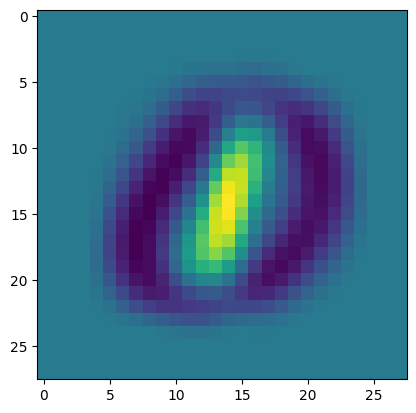

In [ ]:
#------TRAINING CODE --------------

def gaussianClassifierWithIdentityCovariance(Xtrain,ytrain):

    class1_data = Xtrain[ytrain == 0]  # Class 0
    class2_data = Xtrain[ytrain == 1]  # Class 1

    # Estimate means for both classes
    mu1 = np.mean(class1_data, axis=0)
    mu2 = np.mean(class2_data, axis=0)

    weights = mu2 - mu1

    bias = -0.5 * (np.dot((mu2+ mu1),weights))

    a1 = np.concatenate((weights, [bias]))

    return a1


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a1 = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a1[0:784],(28,28)))

train = testLinearClassifier(a1,X_train,y_train)
val = testLinearClassifier(a1,X_val,y_val)
test = testLinearClassifier(a1,X_test,y_test)



## Define and test gaussianClassifierWithCommonCovariance

In [ ]:
class1_demeaned = class1_data - mu1

# For class 2
class2_demeaned = class2_data - mu2

concatenated_demeaned = np.vstack((class1_demeaned, class2_demeaned))

std = np.std(concatenated_demeaned, axis=0)

cov = np.diag(std ** 2)

adjustment_matrix = np.zeros_like(cov)
adjustment_matrix += 1e-6
np.fill_diagonal(adjustment_matrix, 0)
cov += adjustment_matrix

cov_inv = np.linalg.inv(cov)

Mis-classifications= 86 out of 8897, Accuracy percent is given by: 99.03 %
Mis-classifications= 16 out of 1449, Accuracy percent is given by: 98.90 %
Mis-classifications= 44 out of 4434, Accuracy percent is given by: 99.01 %


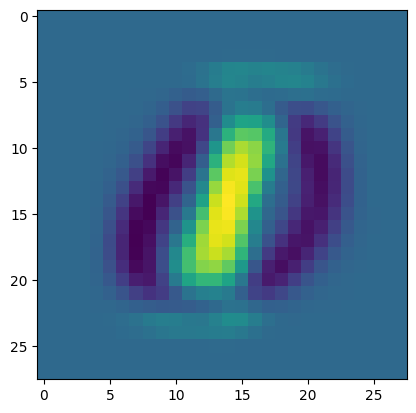

In [ ]:
#------TRAINING CODE --------------

def gaussianClassifierWithCommonCovariance(Xtrain,ytrain):

    class1_data = Xtrain[ytrain == 0]
    class2_data = Xtrain[ytrain == 1]

    # Estimate means for both classes
    mu1 = np.mean(class1_data, axis=0)
    mu2 = np.mean(class2_data, axis=0)

    class1_demeaned = x1 - mu1
    class2_demeaned = x2 - mu2

    # Concatenate both demeaned classes
    concatenated_demeaned = np.vstack((class1_demeaned, class2_demeaned))

    # Compute the std
    std = np.std(concatenated_demeaned, axis=0)

    # Construct the covariance matrix with variances on the diagonal
    cov = np.diag(std ** 2)

    sigma = std**2
    sigma = sigma +  1e-6 * np.eye(sigma.shape[0])

    cov_inv = np.linalg.inv(sigma)

    weights = np.dot((mu2 - mu1).T, cov_inv)
    bias = -0.5 * (np.dot(weights,mu1+mu2))

    a2 = np.concatenate((weights, [bias]))
    return a2


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a2 = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a2[0:784],(28,28)))

train = testLinearClassifier(a2,X_train,y_train)
val = testLinearClassifier(a2,X_val,y_val)
test = testLinearClassifier(a2,X_test,y_test)


## Define and test logisticRegression

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors

In [ ]:
# Add bias term to the training data
X_bias = np.c_[Xtrain, np.ones(Xtrain.shape[0])]  # Augmented input with bias
n_samples, n_features = X_bias.shape

# Initialize weights
a3 = 0.01 * np.random.randn(n_features)

def sigmoid(z):
    # Handle large positive and negative values
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

for i in range(100):
    z = np.dot(X_bias, a)

    predictions = sigmoid(z)

    gradient = np.dot(X_bias.T, (predictions - ytrain))

    a3 -= (1e-4) * gradient

Mis-classifications= 13 out of 8897, Accuracy percent is given by: 99.85 %
Mis-classifications= 0 out of 1449, Accuracy percent is given by: 100.00 %
Mis-classifications= 4 out of 4434, Accuracy percent is given by: 99.91 %


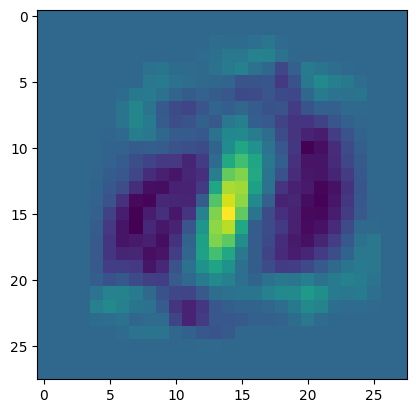

In [ ]:
import numpy as np

def sigmoid(z):
    # Handle large positive and negative values
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def logisticRegression(Xtrain, ytrain, iterations=100, step_size=1e-4, verbose=False):

    X_bias = np.c_[Xtrain, np.ones(Xtrain.shape[0])]
    n_samples, n_features = X_bias.shape

    # Initialize weights
    a3 = 0.01 * np.random.randn(n_features)

    for i in range(iterations):
        z = np.dot(X_bias, a3)

        predictions = sigmoid(z)

        gradient = np.dot(X_bias.T, (predictions - ytrain))

        a3 = a3 - step_size * gradient

    return a3

a3 = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a3[0:784],(28,28)))

train = testLinearClassifier(a3,X_train,y_train)
val = testLinearClassifier(a3,X_val,y_val)
test = testLinearClassifier(a3,X_test,y_test)

Mis-classifications= 8 out of 8897, Accuracy percent is given by: 99.91 %
Mis-classifications= 0 out of 1449, Accuracy percent is given by: 100.00 %
Mis-classifications= 6 out of 4434, Accuracy percent is given by: 99.86 %


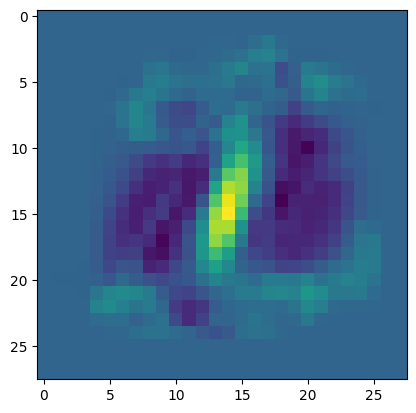

In [ ]:

def sigmoid(z):
    # Handle large positive and negative values
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))


def logisticRegressionWithRegularization(Xtrain, ytrain, iterations=100, step_size=1e-4, lam=1, verbose=False):

    Xtilde = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))
    n_samples, n_features = Xtilde.shape

    a = 0.01 * np.random.randn(n_features)

    for i in range(iterations):
        z = np.dot(Xtilde, a)

        s = sigmoid(z)

        gradient = (np.dot(Xtilde.T, (s - ytrain)) ) + 2* (lam) * a

        gradient[-1] -= (lam / n_samples) * a[-1]

        a -= step_size * gradient

    return a

a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

Mis-classifications= 0 out of 1449, Accuracy percent is given by: 100.00 %
Mis-classifications= 0 out of 1449, Accuracy percent is given by: 100.00 %
Mis-classifications= 1 out of 1449, Accuracy percent is given by: 99.93 %
Mis-classifications= 10 out of 1449, Accuracy percent is given by: 99.31 %
Mis-classifications= 0 out of 1449, Accuracy percent is given by: 100.00 %
Mis-classifications= 6 out of 4434, Accuracy percent is given by: 99.86 %
Optimal λ: 0.01
Test Misclassifications: 6
Test Accuracy: 99.86%


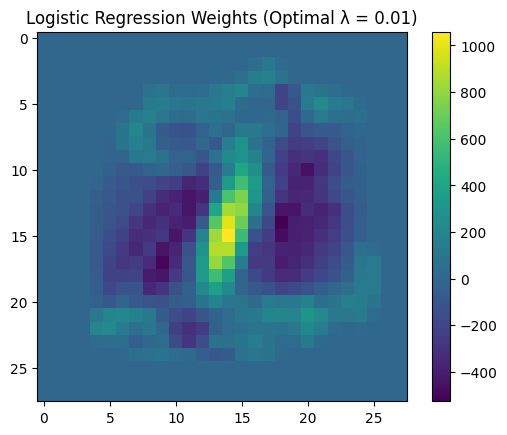

Mis-classifications= 4 out of 8897, Accuracy percent is given by: 99.96 %
Mis-classifications= 0 out of 1449, Accuracy percent is given by: 100.00 %
Mis-classifications= 6 out of 4434, Accuracy percent is given by: 99.86 %
Training Misclassifications: 4
Validation Misclassifications: 0
Test Misclassifications: 6


In [ ]:
def optimizeHyperparameters(Xtrain, ytrain, Xval, yval, Xtest, ytest, iterations=500, step_size=1e-3, verbose=False, lam=1):

    # Define range of λ values to test
    lambda_values = [0.01, 0.1, 1, 10, 100]
    lamopt = None
    best_a = None
    lowest_misclassifications = float('inf')

    # Test each λ value
    for lam in lambda_values:
        a4 = logisticRegressionWithRegularization(Xtrain, ytrain, iterations=iterations, step_size=step_size, lam=lam, verbose=verbose)

        misclassifications = testLinearClassifier(a4, Xval, yval)

        if misclassifications < lowest_misclassifications:
            lowest_misclassifications = misclassifications
            lamopt = lam
            best_a = a4

    test_misclassifications = testLinearClassifier(best_a, Xtest, ytest)
    test_accuracy = 100 - (test_misclassifications / len(ytest)) * 100

    print(f"Optimal λ: {lamopt}")
    print(f"Test Misclassifications: {test_misclassifications}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return lamopt, best_a

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
best_lambda, best_a = optimizeHyperparameters(
    X_train, y_train, X_val, y_val, X_test, y_test, iterations=500, step_size=1e-3, verbose=True
)

plt.imshow(np.reshape(best_a[:784], (28, 28)))
plt.title(f"Logistic Regression Weights (Optimal λ = {best_lambda})")
plt.colorbar()
plt.show()

# Evaluate the best model
train_misclassifications = testLinearClassifier(best_a, X_train, y_train)
val_misclassifications = testLinearClassifier(best_a, X_val, y_val)
test_misclassifications = testLinearClassifier(best_a, X_test, y_test)

print(f"Training Misclassifications: {train_misclassifications}")
print(f"Validation Misclassifications: {val_misclassifications}")
print(f"Test Misclassifications: {test_misclassifications}")



# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [ ]:
def compareClassifiers(X_train, y_train, X_val, y_val, X_test, y_test, iterations=500, step_size=1e-4, lam=0.1):

    print("Training and evaluating classifiers...\n")

    # 1. Gaussian Classifier with Identity Covariance
    print("1. Gaussian Classifier with Identity Covariance")
    a1 = gaussianClassifierWithIdentityCovariance(X_train, y_train)
    test_misclassifications_a1 = testLinearClassifier(a1, X_test, y_test)
    print(f"Test Misclassifications (Gaussian with Identity Covariance): {test_misclassifications_a1}")

    # 2. Gaussian Classifier with Common Covariance
    print("\n2. Gaussian Classifier with Common Covariance")
    a2 = gaussianClassifierWithCommonCovariance(X_train, y_train)
    test_misclassifications_a2 = testLinearClassifier(a2, X_test, y_test)
    print(f"Test Misclassifications (Gaussian with Common Covariance): {test_misclassifications_a2}")

    # 3. Logistic Regression
    print("\n3. Logistic Regression")
    a3 = logisticRegression(X_train, y_train, iterations=iterations, step_size=step_size, verbose=False)
    test_misclassifications_a3 = testLinearClassifier(a3, X_test, y_test)
    print(f"Test Misclassifications (Logistic Regression): {test_misclassifications_a3}")

    # 4. Logistic Regression with Regularization
    print("\n4. Logistic Regression with Regularization")
    a4 = logisticRegressionWithRegularization(X_train, y_train, iterations=iterations, step_size=step_size, lam=lam, verbose=False)
    test_misclassifications_a4 = testLinearClassifier(a4, X_test, y_test)
    print(f"Test Misclassifications (Logistic Regression with Regularization, λ={lam}): {test_misclassifications_a4}")

    # Summary
    print("\nSummary of Test Misclassifications:")
    print(f"Gaussian with Identity Covariance: {test_misclassifications_a1}")
    print(f"Gaussian with Common Covariance: {test_misclassifications_a2}")
    print(f"Logistic Regression: {test_misclassifications_a3}")
    print(f"Logistic Regression with Regularization (λ={lam}): {test_misclassifications_a4}")


In [ ]:
compareClassifiers(X_train, y_train, X_val, y_val, X_test, y_test, iterations=500, step_size=1e-4, lam=0.1)


Training and evaluating classifiers...

1. Gaussian Classifier with Identity Covariance
Mis-classifications= 36 out of 4434, Accuracy percent is given by: 99.19 %
Test Misclassifications (Gaussian with Identity Covariance): 36

2. Gaussian Classifier with Common Covariance
Mis-classifications= 44 out of 4434, Accuracy percent is given by: 99.01 %
Test Misclassifications (Gaussian with Common Covariance): 44

3. Logistic Regression
Mis-classifications= 5 out of 4434, Accuracy percent is given by: 99.89 %
Test Misclassifications (Logistic Regression): 5

4. Logistic Regression with Regularization
Mis-classifications= 6 out of 4434, Accuracy percent is given by: 99.86 %
Test Misclassifications (Logistic Regression with Regularization, λ=0.1): 6

Summary of Test Misclassifications:
Gaussian with Identity Covariance: 36
Gaussian with Common Covariance: 44
Logistic Regression: 5
Logistic Regression with Regularization (λ=0.1): 6
